Ich werde verschiedene Modelle trainieren und sie vergleichen.\
Kriterien sind:
- Dauer des Trainings
- Größe des Modells
- Genauigkeit in der Erkennung der verschiedenen Katzen

# YoloV11

# MobileNetV2

- Dauer des Trainings:
    - 17 min

- Größe des Modells
    - 8935 KB

- Genauigkeit des Modells:
  -  Val-Loss=0.0975 
  -  Val-Acc=0.9485
-  Test-Loss:
-  

In [1]:
#!pip install torch torchvision

In [2]:
import torch
import os

from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import mobilenet_v2
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt


In [3]:
src_directory = r"\\Cloud_9\data\pet_feeder_ai\cats"
dst_directory = r"\\Cloud_9\data\pet_feeder_ai\data_split"
class_names   = ["Elsa", "Fabius"]

In [4]:
train_directory = os.path.join(dst_directory, "train")
val_directory   = os.path.join(dst_directory, "val")
test_directory  = os.path.join(dst_directory, "test")

In [5]:
# Augmentierung für Training
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std= [0.229,0.224,0.225]),
])

In [6]:
# Nur Resize+Norm für Val/Test
eval_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std= [0.229,0.224,0.225]),
])


In [ ]:
class DebugImageFolder(ImageFolder):
    def __getitem__(self, index):
        path, label = self.samples[index]
        try:
            # versuche, das Bild zu öffnen und zu transformieren
            img = Image.open(path).convert("RGB")
            if self.transform:
                img = self.transform(img)
            if self.target_transform:
                label = self.target_transform(label)
            return img, label
        except Exception as e:
            # gib den defekten Pfad aus und wirf den Fehler neu
            print(f"⚠️ Fehler beim Laden von: {path}\n   {e}")
            raise

train_ds = DebugImageFolder(train_directory, transform=train_transforms)
val_ds   = DebugImageFolder(val_directory,   transform=eval_transforms)
test_ds = DebugImageFolder(test_directory,   transform=eval_transforms)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0)
val_dl   = DataLoader(val_ds,   batch_size=32, shuffle=True, num_workers=0)
test_dl = DataLoader(test_ds,   batch_size=32, shuffle=True, num_workers=0)


In [8]:
model = mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


c:\Users\dtisl\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dtisl\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

best_val_loss = float('inf')
patience = 5
counter = 0


for epoch in range(1, 21):
    # Training
    model.train()
    running_loss = 0
    for xb, yb in tqdm(train_dl, desc=f"[Epoch {epoch:02d}] Training", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    # Validation
    model.eval()
    val_loss = 0
    correct = total = 0
    with torch.no_grad(): 
        for xb, yb in tqdm(val_dl, desc=f"[Epoch {epoch:02d}] Validation", leave=False):
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            val_loss += criterion(logits, yb).item() * xb.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    val_loss /= len(val_ds)
    val_acc = correct / total

    print(
        f"Epoch {epoch:02d} | "
        f"Train-Loss={(running_loss / len(train_ds)):.4f} | "
        f"Val-Loss={val_loss:.4f} | Val-Acc={val_acc:.4f}"
    )

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'catid_mobilenetv2.pt')
        print(" → Neues Bestmodell gespeichert")
    else:
        counter += 1
        print(f" → Keine Verbesserung ({counter}/{patience})")
        if counter >= patience:
            print(f"Abbruch nach {patience} Epochen ohne Verbesserung.")
            break


Epoch 01 | Train-Loss=0.0701 | Val-Loss=0.1858 | Val-Acc=0.8837
 → Neues Bestmodell gespeichert


Epoch 02 | Train-Loss=0.0675 | Val-Loss=0.2805 | Val-Acc=0.9070
 → Keine Verbesserung (1/5)


Epoch 03 | Train-Loss=0.0520 | Val-Loss=0.1512 | Val-Acc=0.9186
 → Neues Bestmodell gespeichert


Epoch 04 | Train-Loss=0.0358 | Val-Loss=0.2054 | Val-Acc=0.9070
 → Keine Verbesserung (1/5)


Epoch 05 | Train-Loss=0.0309 | Val-Loss=0.2510 | Val-Acc=0.9186
 → Keine Verbesserung (2/5)


Epoch 06 | Train-Loss=0.0598 | Val-Loss=0.2505 | Val-Acc=0.8953
 → Keine Verbesserung (3/5)


Epoch 07 | Train-Loss=0.0244 | Val-Loss=0.1827 | Val-Acc=0.9186
 → Keine Verbesserung (4/5)


Epoch 08 | Train-Loss=0.0140 | Val-Loss=0.1776 | Val-Acc=0.9302
 → Keine Verbesserung (5/5)
Abbruch nach 5 Epochen ohne Verbesserung.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

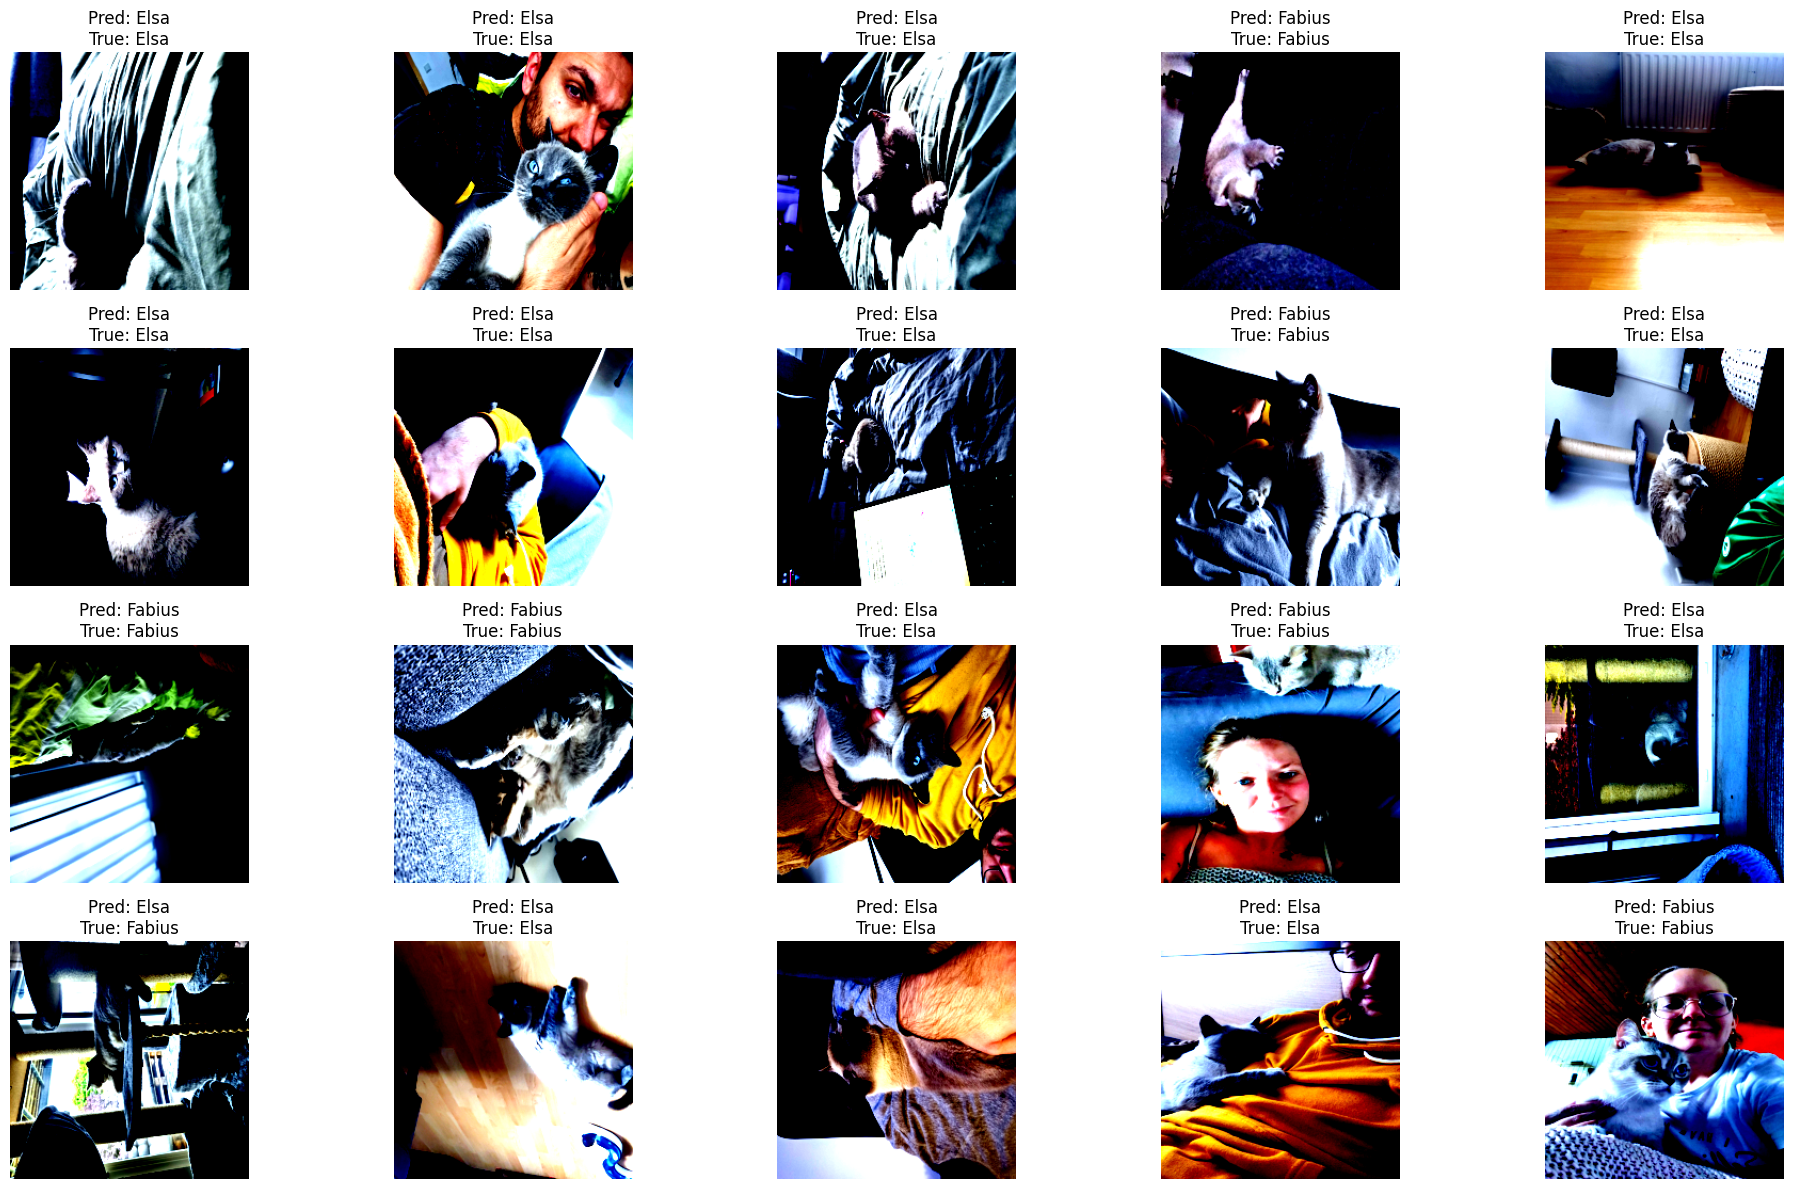

In [12]:
model.eval()

images_to_show = []
preds_list = []
labels_list = []

with torch.no_grad():
    for xb, yb in test_dl:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1)

       
        images_to_show.extend(xb.cpu())
        preds_list.extend(preds.cpu())
        labels_list.extend(yb.cpu())


plt.figure(figsize=(20, 12))
for i in range(min(20, len(images_to_show))): 
    plt.subplot(4, 5, i + 1)
    img = images_to_show[i].permute(1, 2, 0) 
    plt.imshow(img)
    plt.title(f"Pred: {class_names[preds_list[i]]}\nTrue: {class_names[labels_list[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# EfficientNet-Lite0 